In [3]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
from scipy.spatial import distance
import time
import platform

from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, load_network, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import create_datasets

transformVar = {"Test": transforms.Compose([
    transforms.Resize(128),    #Already 184 x 184
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     normalize
]),
    "Train": transforms.Compose([
    transforms.Resize(128),  # Already 184 x 184
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#     normalize
    ])
}

In [4]:
logging.basicConfig(format='%(message)s',level=logging.INFO)
channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nr_net = 0 

version = nr_net + 10
num_input_frames = 5
num_output_frames = 10
network_type = "7_kernel_3LSTM"

if 'Darwin' in platform.system():
    data_dir = './'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("./Results"):
    os.mkdir("./Results")
results_dir = "./Results/" + network_type + "_v%03d/" % version

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)
    
# Data
filename_data = results_dir + "all_data.pickle"
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = Create_Datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)

train_dataset.root_dir = './Video_Data/'
val_dataset.root_dir = './Video_Data/'
test_dataset.root_dir = './Video_Data/'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

model = Network(device, channels)
model = load_network(model, device, "Results/7_kernel_3LSTM_v010/model.pt")

Loading datasets


In [8]:
from utils.training import test
from utils.Scorekeeper import Scorekeeper
score_keeper = Scorekeeper()

1 out of 31
Correct: 0	Percentile: 0%
/Users/stathis/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


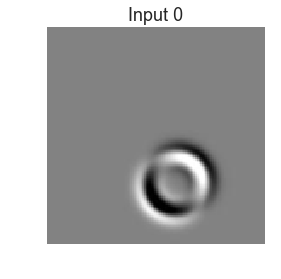

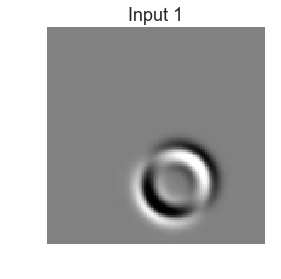

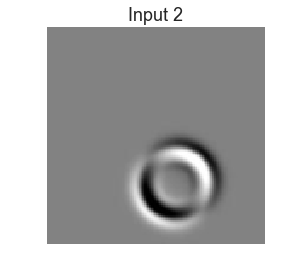

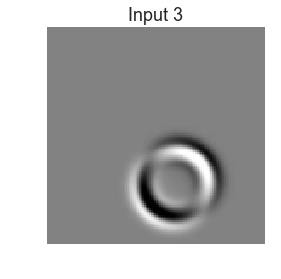

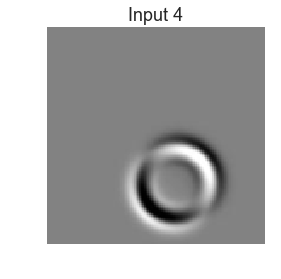

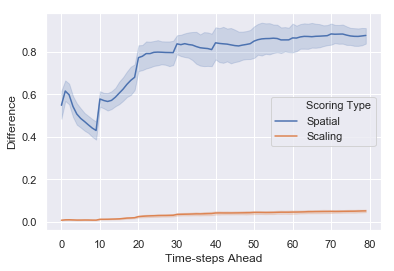

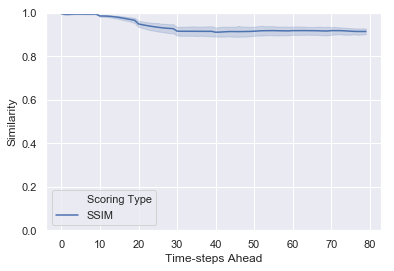

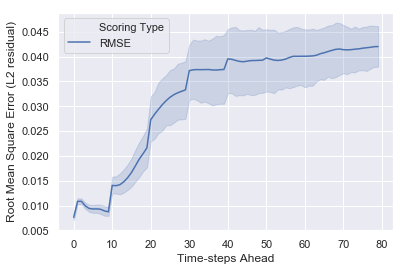

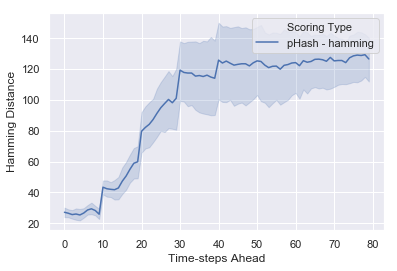

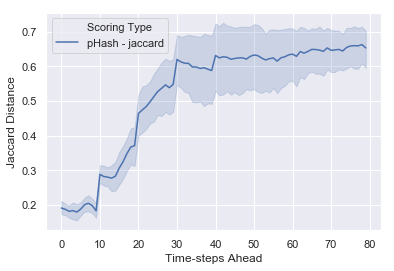

In [9]:
test(model, test_dataloader, num_input_frames, num_output_frames, channels, device, score_keeper, results_dir, plot=False)